In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# For deep learning
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing as keras_preprocessing

print(tf.__version__)


2.4.1


In [3]:
# # for when working in google colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
# import data

# data_file = '/content/drive/MyDrive/6862_project/QCFilteredData.csv'  ### when working in google colab
data_file = '../data/GOSHIP_Data/QCFilteredData.csv'
### ignore lat lon for now. Add later after zoning
### ignore month for now. One-hot encode later
data = pd.read_csv(data_file, header=0, usecols=[3,4,5,6,7,8,9,10,11], 
                   names=['lat','lon','pres','temp','sal','oxy','nitr','phsp','sili'])

In [5]:
# display data

data

,lat,lon,pres,temp,sal,oxy,nitr,phsp,sili
0,-45.000,146.2200,4.1,15.7440,35.4240,241.6,2.37,0.140,0.15
1,-45.000,146.2200,22.0,15.5310,35.3940,241.8,2.54,0.150,0.18
2,-45.000,146.2200,51.5,14.4770,35.2600,239.1,4.68,0.280,0.66
3,-45.000,146.2200,202.8,12.3210,35.1620,224.9,10.52,0.590,2.74
4,-45.000,146.2200,498.6,9.0490,34.6360,247.7,16.62,0.960,4.25
...,...,...,...,...,...,...,...,...,...
42407,-60.013,-30.8953,1697.8,0.0694,34.6681,218.5,32.60,2.251,121.10
42408,-60.013,-30.8953,1996.5,-0.0152,34.6641,222.7,32.40,2.247,121.90
42409,-60.013,-30.8953,2299.0,-0.0551,34.6618,224.9,32.50,2.247,122.90
42410,-60.013,-30.8953,2597.7,-0.0707,34.6601,226.8,32.40,2.248,123.80


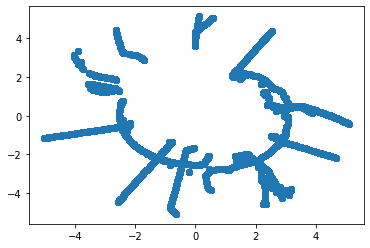

In [6]:
# project coordinates to cartesian (i.e. easting, northing)

from pyproj import Proj, Transformer

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")

def transform_coords(x):
    return transformer.transform(x[0],x[1])

tmp = data[["lat","lon"]].apply(transform_coords, axis=1)
data['easting'] = tmp.apply(lambda x: x[0]/1e6)
data['northing'] = tmp.apply(lambda x: x[1]/1e6)
data.drop(['lat','lon'], inplace=True, axis='columns') # remove latitude and longitude

plt.scatter(data['easting'], data['northing'])
plt.show() # plot

In [7]:
# split data into training, validation, testing set

train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

In [8]:
# separate out coordinates from rest of features
# separate out labels (phsp, sili)

train_features = train_dataset.copy()
train_coords = train_features[['easting','northing']]
train_features.drop(['easting','northing'], inplace=True, axis='columns')

test_features = test_dataset.copy()
test_coords = test_features[['easting','northing']]
test_features.drop(['easting','northing'], inplace=True, axis='columns')

train_phsp = train_features.pop('phsp')
train_sili = train_features.pop('sili')

test_phsp = test_features.pop('phsp')
test_sili = test_features.pop('sili')

In [9]:
# scale features
# note we do not scale easting and northing
from joblib import dump, load

scaler = StandardScaler()
scaler.fit(train_features)
dump(scaler, 'scaler.bin', compress=True) ### save scaler for later use
### to load back, scaler=load('scaler.bin')

scaled_train_features = scaler.transform(train_features)
print("scaled train features means: \n", scaled_train_features.mean(axis=0))
print("scaled train features standard deviations: \n", scaled_train_features.std(axis=0))

# concatenate coordinates and training features
training_features = np.concatenate([train_coords, scaled_train_features],axis=1)

# scale test features and concatenate
scaled_test_features = scaler.transform(test_features) # apply same scaler object to test features
testing_features = np.concatenate([test_coords, scaled_test_features],axis=1)

scaled train features means: 
 [ 8.80587151e-17  7.74832927e-18 -9.89692004e-16  1.34601044e-16
  4.11289694e-16]
scaled train features standard deviations: 
 [1. 1. 1. 1. 1.]


In [10]:
# create dropout layer
# from tensorflow.keras.layers.core import Lambda
from tensorflow.keras import backend as K

def PermaDropout(rate):
    return keras.layers.Lambda(lambda x: K.dropout(x, level=rate))

In [11]:
# linear regression model for phsp

linear_model_phsp = tf.keras.Sequential([PermaDropout(0.2), layers.Dense(units=1)])

linear_model_phsp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

history = linear_model_phsp.fit(
    training_features, train_phsp, 
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

linear_model_phsp.save('linear_model_phsp')
# to load model back, model = keras.models.load_model('path/to/location')


Epoch 1/100
849/849 [==============================] - 2s 2ms/step - loss: 4.2368 - val_loss: 1.7446
Epoch 2/100
849/849 [==============================] - 1s 759us/step - loss: 1.3289 - val_loss: 0.5180
Epoch 3/100
849/849 [==============================] - 1s 722us/step - loss: 0.3772 - val_loss: 0.1083
Epoch 4/100
849/849 [==============================] - 1s 719us/step - loss: 0.0756 - val_loss: 0.0237
Epoch 5/100
849/849 [==============================] - 1s 727us/step - loss: 0.0224 - val_loss: 0.0173
Epoch 6/100
849/849 [==============================] - 1s 812us/step - loss: 0.0185 - val_loss: 0.0171
Epoch 7/100
849/849 [==============================] - 1s 796us/step - loss: 0.0177 - val_loss: 0.0157
Epoch 8/100
849/849 [==============================] - 1s 863us/step - loss: 0.0180 - val_loss: 0.0178
Epoch 9/100
849/849 [==============================] - 1s 726us/step - loss: 0.0186 - val_loss: 0.0164
Epoch 10/100
849/849 [==============================] - 1s 1ms/step - loss:

Epoch 80/100
849/849 [==============================] - 1s 682us/step - loss: 0.0188 - val_loss: 0.0191
Epoch 81/100
849/849 [==============================] - 1s 723us/step - loss: 0.0183 - val_loss: 0.0179
Epoch 82/100
849/849 [==============================] - 1s 683us/step - loss: 0.0174 - val_loss: 0.0172
Epoch 83/100
849/849 [==============================] - 1s 671us/step - loss: 0.0188 - val_loss: 0.0172
Epoch 84/100
849/849 [==============================] - 1s 671us/step - loss: 0.0171 - val_loss: 0.0167
Epoch 85/100
849/849 [==============================] - 1s 678us/step - loss: 0.0175 - val_loss: 0.0170
Epoch 86/100
849/849 [==============================] - 1s 747us/step - loss: 0.0178 - val_loss: 0.0168
Epoch 87/100
849/849 [==============================] - 1s 767us/step - loss: 0.0178 - val_loss: 0.0176
Epoch 88/100
849/849 [==============================] - 1s 729us/step - loss: 0.0190 - val_loss: 0.0173
Epoch 89/100
849/849 [==============================] - 1s 686us

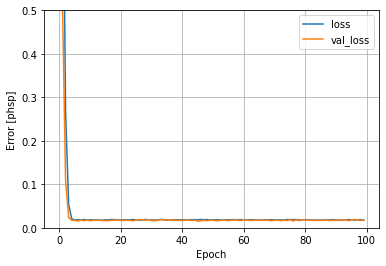

In [12]:
# plot convergence curves

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 0.5])
plt.xlabel('Epoch')
plt.ylabel('Error [phsp]')
plt.legend()
plt.grid(True)

In [13]:
# predict phsp with dropout (100 times)

predictions_lst = []
for i in range(100):
    test_predictions = linear_model_phsp.predict(testing_features).flatten()
    predictions_lst.append(test_predictions)

In [14]:
# get means and standard deviations

linear_phsp_arr = np.array(predictions_lst)
linear_phsp_mean = np.mean(linear_phsp_arr, axis=0)
linear_phsp_sd = np.std(linear_phsp_arr, axis=0)

Text(0, 0.5, 'Predictions [phsp]')

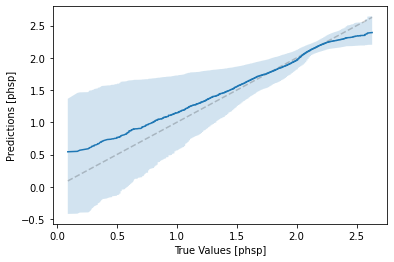

In [15]:
# plot confidence intervals

min_val = np.min(test_phsp)
max_val = np.max(test_phsp)
fig, ax = plt.subplots()
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.plot(np.sort(test_phsp), np.sort(linear_phsp_mean))
ax.fill_between(np.sort(test_phsp), np.sort(linear_phsp_mean - 1.96*linear_phsp_sd), 
                np.sort(linear_phsp_mean + 1.96*linear_phsp_sd), alpha=0.2)
plt.xlabel('True Values [phsp]')
plt.ylabel('Predictions [phsp]')

In [16]:
# linear regression model for sili

linear_model_sili = tf.keras.Sequential([PermaDropout(0.2), layers.Dense(units=1)])

linear_model_sili.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

history = linear_model_sili.fit(
    training_features, train_sili, 
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

linear_model_sili.save('linear_model_sili')
# to load model back, model = keras.models.load_model('path/to/location')

Epoch 1/100
849/849 [==============================] - 1s 819us/step - loss: 7897.1283 - val_loss: 7531.1729
Epoch 2/100
849/849 [==============================] - 1s 742us/step - loss: 7500.6716 - val_loss: 7166.8345
Epoch 3/100
849/849 [==============================] - 1s 775us/step - loss: 7089.3023 - val_loss: 6842.9238
Epoch 4/100
849/849 [==============================] - 1s 712us/step - loss: 6778.8691 - val_loss: 6542.4731
Epoch 5/100
849/849 [==============================] - 1s 705us/step - loss: 6482.1469 - val_loss: 6251.5015
Epoch 6/100
849/849 [==============================] - 1s 709us/step - loss: 6125.0880 - val_loss: 6019.9580
Epoch 7/100
849/849 [==============================] - 1s 727us/step - loss: 5953.5680 - val_loss: 5803.5210
Epoch 8/100
849/849 [==============================] - 1s 708us/step - loss: 5745.2414 - val_loss: 5602.7134
Epoch 9/100
849/849 [==============================] - 1s 728us/step - loss: 5535.7299 - val_loss: 5397.2480
Epoch 10/100
849/84

Epoch 76/100
849/849 [==============================] - 1s 708us/step - loss: 607.9052 - val_loss: 571.6911
Epoch 77/100
849/849 [==============================] - 1s 703us/step - loss: 581.5385 - val_loss: 546.5346
Epoch 78/100
849/849 [==============================] - 1s 705us/step - loss: 554.0865 - val_loss: 538.7121
Epoch 79/100
849/849 [==============================] - 1s 740us/step - loss: 519.8254 - val_loss: 497.9491
Epoch 80/100
849/849 [==============================] - 1s 693us/step - loss: 506.4477 - val_loss: 477.8983
Epoch 81/100
849/849 [==============================] - 1s 698us/step - loss: 481.0540 - val_loss: 455.9765
Epoch 82/100
849/849 [==============================] - 1s 712us/step - loss: 461.0683 - val_loss: 442.1199
Epoch 83/100
849/849 [==============================] - 1s 708us/step - loss: 457.9431 - val_loss: 421.4745
Epoch 84/100
849/849 [==============================] - 1s 731us/step - loss: 434.3579 - val_loss: 409.0312
Epoch 85/100
849/849 [======

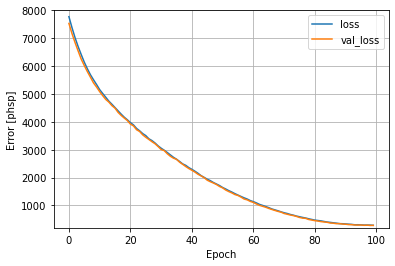

In [17]:
# plot convergence curves

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([200, 8000])
plt.xlabel('Epoch')
plt.ylabel('Error [phsp]')
plt.legend()
plt.grid(True)

In [18]:
# predict sili with dropout (100 times)

predictions_lst = []
for i in range(100):
    test_predictions = linear_model_sili.predict(testing_features).flatten()
    predictions_lst.append(test_predictions)

In [19]:
# compute means and standard deviations

linear_sili_arr = np.array(predictions_lst)
linear_sili_mean = np.mean(linear_sili_arr, axis=0)
linear_sili_sd = np.std(linear_sili_arr, axis=0)


Text(0, 0.5, 'Predictions [sili]')

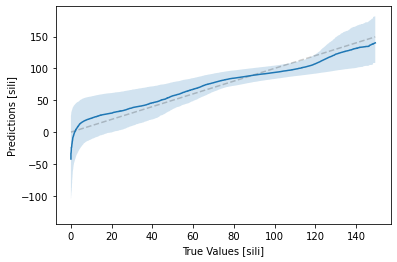

In [20]:
# plot confidence intervals

min_val = np.min(test_sili)
max_val = np.max(test_sili)
fig, ax = plt.subplots()
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.plot(np.sort(test_sili), np.sort(linear_sili_mean), '-')
ax.fill_between(np.sort(test_sili), np.sort(linear_sili_mean - 1.96*linear_sili_sd), 
                np.sort(linear_sili_mean + 1.96*linear_sili_sd), alpha=0.2)
plt.xlabel('True Values [sili]')
plt.ylabel('Predictions [sili]')

In [21]:
# save results for later

test_results = {}
test_results['linear_model_phsp'] = linear_model_phsp.evaluate(testing_features, test_phsp, verbose=0)
test_results['linear_model_sili'] = linear_model_sili.evaluate(testing_features, test_sili, verbose=0)


In [22]:
# dnn model for phsp

dnn_model_phsp = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      PermaDropout(0.2),
      layers.Dense(1)
  ])

dnn_model_phsp.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

history = dnn_model_phsp.fit(
    training_features, train_phsp,
    validation_split=0.2,
    verbose=1, epochs=100)

dnn_model_phsp.save('dnn_model_phsp')
# to load model back, model = keras.models.load_model('path/to/location')

Epoch 1/100
849/849 [==============================] - 1s 1ms/step - loss: 0.3502 - val_loss: 0.0468
Epoch 2/100
849/849 [==============================] - 1s 970us/step - loss: 0.0446 - val_loss: 0.0355
Epoch 3/100
849/849 [==============================] - 1s 995us/step - loss: 0.0331 - val_loss: 0.0314
Epoch 4/100
849/849 [==============================] - 1s 968us/step - loss: 0.0257 - val_loss: 0.0218
Epoch 5/100
849/849 [==============================] - 1s 965us/step - loss: 0.0205 - val_loss: 0.0171
Epoch 6/100
849/849 [==============================] - 1s 978us/step - loss: 0.0158 - val_loss: 0.0131
Epoch 7/100
849/849 [==============================] - 1s 975us/step - loss: 0.0117 - val_loss: 0.0094
Epoch 8/100
849/849 [==============================] - 1s 959us/step - loss: 0.0093 - val_loss: 0.0075
Epoch 9/100
849/849 [==============================] - 1s 955us/step - loss: 0.0070 - val_loss: 0.0060
Epoch 10/100
849/849 [==============================] - 1s 973us/step - los

Epoch 80/100
849/849 [==============================] - 1s 975us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 81/100
849/849 [==============================] - 1s 941us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 82/100
849/849 [==============================] - 1s 941us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 83/100
849/849 [==============================] - 1s 932us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 84/100
849/849 [==============================] - 1s 962us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 85/100
849/849 [==============================] - 1s 953us/step - loss: 0.0032 - val_loss: 0.0034
Epoch 86/100
849/849 [==============================] - 1s 943us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 87/100
849/849 [==============================] - 1s 966us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 88/100
849/849 [==============================] - 1s 959us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 89/100
849/849 [==============================] - 1s 941us

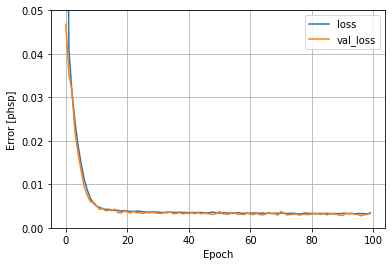

In [23]:
# plot convergence curves

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0.0, 0.05])
plt.xlabel('Epoch')
plt.ylabel('Error [phsp]')
plt.legend()
plt.grid(True)


In [24]:
# predict phsp with dropout (100 times)

predictions_lst = []
for i in range(100):
    test_predictions = dnn_model_phsp.predict(testing_features).flatten()
    predictions_lst.append(test_predictions)

In [25]:
# compute means and standard deviations

dnn_phsp_arr = np.array(predictions_lst)
dnn_phsp_mean = np.mean(dnn_phsp_arr, axis=0)
dnn_phsp_sd = np.std(dnn_phsp_arr, axis=0)

Text(0, 0.5, 'Predictions [phsp]')

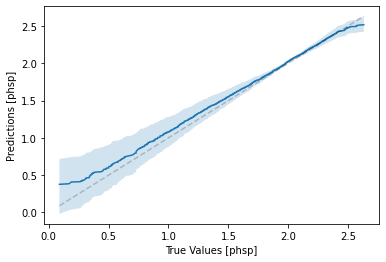

In [26]:
# plot confidence intervals

min_val = np.min(test_phsp)
max_val = np.max(test_phsp)
fig, ax = plt.subplots()
ax.plot(np.sort(test_phsp), np.sort(dnn_phsp_mean), '-')
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.fill_between(np.sort(test_phsp), np.sort(dnn_phsp_mean - 1.96*dnn_phsp_sd), 
                np.sort(dnn_phsp_mean + 1.96*dnn_phsp_sd), alpha=0.2)
plt.xlabel('True Values [phsp]')
plt.ylabel('Predictions [phsp]')

In [27]:
# dnn model for sili

dnn_model_sili = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      PermaDropout(0.2),
      layers.Dense(1)
  ])

dnn_model_sili.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

history = dnn_model_sili.fit(
    training_features, train_sili,
    validation_split=0.2,
    verbose=1, epochs=100)

dnn_model_sili.save('dnn_model_sili')
# to load model back, model = keras.models.load_model('path/to/location')

Epoch 1/100
849/849 [==============================] - 1s 1ms/step - loss: 2840.1407 - val_loss: 133.1743
Epoch 2/100
849/849 [==============================] - 1s 954us/step - loss: 126.1090 - val_loss: 110.7517
Epoch 3/100
849/849 [==============================] - 1s 989us/step - loss: 108.7323 - val_loss: 102.3755
Epoch 4/100
849/849 [==============================] - 1s 953us/step - loss: 102.0805 - val_loss: 98.0623
Epoch 5/100
849/849 [==============================] - 1s 958us/step - loss: 98.9817 - val_loss: 94.0158
Epoch 6/100
849/849 [==============================] - 1s 968us/step - loss: 92.9192 - val_loss: 91.2157
Epoch 7/100
849/849 [==============================] - 1s 990us/step - loss: 92.8315 - val_loss: 90.8046
Epoch 8/100
849/849 [==============================] - 1s 975us/step - loss: 90.6267 - val_loss: 88.6467
Epoch 9/100
849/849 [==============================] - 1s 954us/step - loss: 89.2890 - val_loss: 84.3364
Epoch 10/100
849/849 [===========================

849/849 [==============================] - 1s 948us/step - loss: 55.0592 - val_loss: 53.4947
Epoch 79/100
849/849 [==============================] - 1s 944us/step - loss: 55.7346 - val_loss: 52.9801
Epoch 80/100
849/849 [==============================] - 1s 973us/step - loss: 53.3241 - val_loss: 53.7242
Epoch 81/100
849/849 [==============================] - 1s 931us/step - loss: 52.8724 - val_loss: 51.8341
Epoch 82/100
849/849 [==============================] - 1s 948us/step - loss: 52.4285 - val_loss: 52.0420
Epoch 83/100
849/849 [==============================] - 1s 940us/step - loss: 53.0595 - val_loss: 52.9620
Epoch 84/100
849/849 [==============================] - 1s 966us/step - loss: 54.1318 - val_loss: 51.1142
Epoch 85/100
849/849 [==============================] - 1s 945us/step - loss: 53.0471 - val_loss: 51.3240
Epoch 86/100
849/849 [==============================] - 1s 937us/step - loss: 52.3838 - val_loss: 53.4265
Epoch 87/100
849/849 [==============================] - 1s 

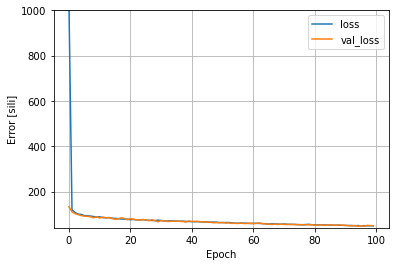

In [28]:
# plot convergence curves

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([40, 1000])
plt.xlabel('Epoch')
plt.ylabel('Error [sili]')
plt.legend()
plt.grid(True)


In [29]:
# predict sili with dropout (100 times)

predictions_lst = []
for i in range(100):
    test_predictions = dnn_model_sili.predict(testing_features).flatten()
    predictions_lst.append(test_predictions)

In [30]:
# compute means and standard deviations

dnn_sili_arr = np.array(predictions_lst)
dnn_sili_mean = np.mean(dnn_sili_arr, axis=0)
dnn_sili_sd = np.std(dnn_sili_arr, axis=0)

Text(0, 0.5, 'Predictions [sili]')

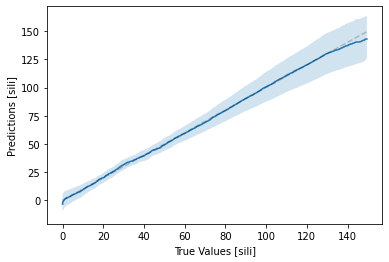

In [31]:
# plot confidence intervals

min_val = np.min(test_sili)
max_val = np.max(test_sili)
fig, ax = plt.subplots()
ax.plot(np.sort(test_sili), np.sort(dnn_sili_mean), '-')
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.fill_between(np.sort(test_sili), np.sort(dnn_sili_mean - 1.96*dnn_sili_sd), 
                np.sort(dnn_sili_mean + 1.96*dnn_sili_sd), alpha=0.2)
plt.xlabel('True Values [sili]')
plt.ylabel('Predictions [sili]')

In [32]:
# save errors

test_results['dnn_phsp_model'] = dnn_model_phsp.evaluate(testing_features, test_phsp, verbose=0)
test_results['dnn_sili_model'] = dnn_model_sili.evaluate(testing_features, test_sili, verbose=0)

In [33]:
# test results dataframe

pd.DataFrame(test_results, index=['Mean squared error']).T

,Mean squared error
linear_model_phsp,0.017792
linear_model_sili,299.427002
dnn_phsp_model,0.003661
dnn_sili_model,47.846264


Text(0, 0.5, 'predicted sili')

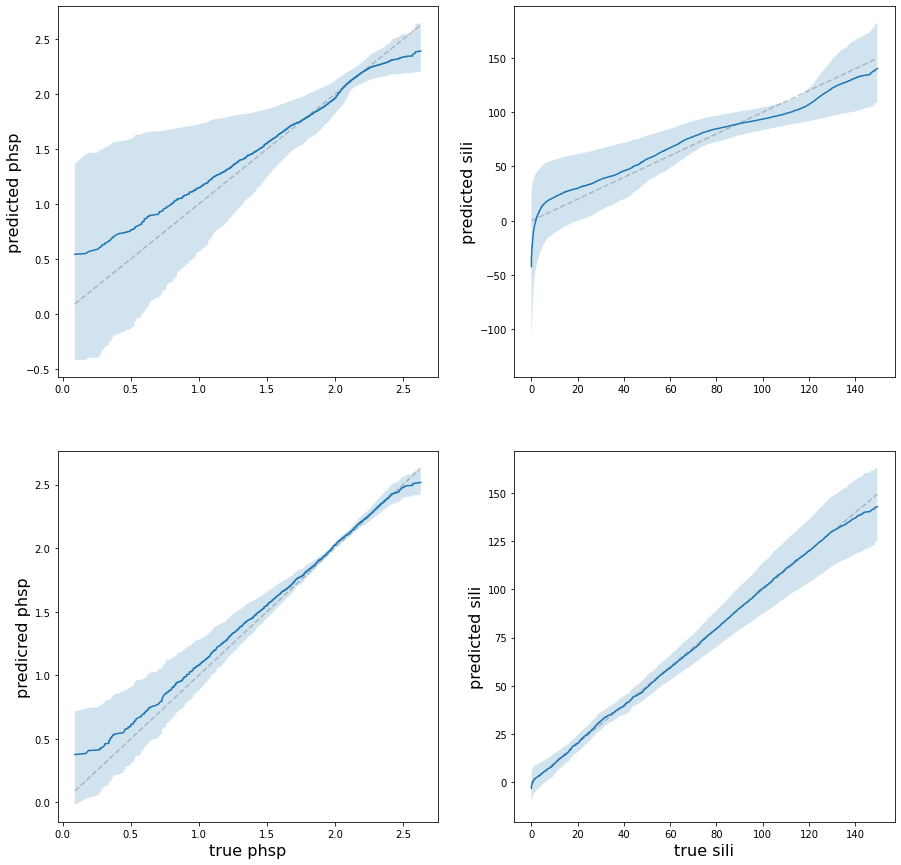

In [34]:
# plot confidence intervals in single plot

min_phsp = np.min(test_phsp)
max_phsp = np.max(test_phsp)
min_sili = np.min(test_sili)
max_sili = np.max(test_sili)


fig, axs = plt.subplots(2, 2, figsize=(15,15))

# regression phsp
axs[0, 0].plot(np.linspace(min_phsp,max_phsp,100),np.linspace(min_phsp,max_phsp,100), 'k--', alpha=0.2)
axs[0, 0].plot(np.sort(test_phsp), np.sort(linear_phsp_mean))
axs[0, 0].fill_between(np.sort(test_phsp), np.sort(linear_phsp_mean - 1.96*linear_phsp_sd), 
                np.sort(linear_phsp_mean + 1.96*linear_phsp_sd), alpha=0.2)
# axs[0, 0].set_title('Axis [0, 0]')

# regression sili
axs[0, 1].plot(np.linspace(min_sili,max_sili,100),np.linspace(min_sili,max_sili,100), 'k--', alpha=0.2)
axs[0, 1].plot(np.sort(test_sili), np.sort(linear_sili_mean))
axs[0, 1].fill_between(np.sort(test_sili), np.sort(linear_sili_mean - 1.96*linear_sili_sd), 
                np.sort(linear_sili_mean + 1.96*linear_sili_sd), alpha=0.2)

# dnn phsp
axs[1, 0].plot(np.linspace(min_phsp,max_phsp,100),np.linspace(min_phsp,max_phsp,100), 'k--', alpha=0.2)
axs[1, 0].plot(np.sort(test_phsp), np.sort(dnn_phsp_mean))
axs[1, 0].fill_between(np.sort(test_phsp), np.sort(dnn_phsp_mean - 1.96*dnn_phsp_sd), 
                np.sort(dnn_phsp_mean + 1.96*dnn_phsp_sd), alpha=0.2)

# dnn sili
axs[1, 1].plot(np.linspace(min_sili,max_sili,100),np.linspace(min_sili,max_sili,100), 'k--', alpha=0.2)
axs[1, 1].plot(np.sort(test_sili), np.sort(dnn_sili_mean))
axs[1, 1].fill_between(np.sort(test_sili), np.sort(dnn_sili_mean - 1.96*dnn_sili_sd), 
                np.sort(dnn_sili_mean + 1.96*dnn_sili_sd), alpha=0.2)

axs[1,0].set_xlabel('true phsp', fontsize=16)
axs[0,0].set_ylabel('predicted phsp', fontsize=16)
axs[1,0].set_ylabel('predicred phsp', fontsize=16)
axs[1,1].set_xlabel('true sili', fontsize=16)
axs[0,1].set_ylabel('predicted sili', fontsize=16)
axs[1,1].set_ylabel('predicted sili', fontsize=16)
